In [1]:
# %%
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from tqdm.auto import tqdm

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

from typing import Any, Callable, Sequence, Union
import numpy as np
import scipy.stats as stats

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import jax
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange, repeat
import wandb

from iqadatasets.datasets import *
from fxlayers.layers import *
from fxlayers.layers import GaborLayerLogSigma_, GaussianLayerGamma, FreqGaussianGamma, OrientGaussianGamma
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

2024-10-08 11:36:23.155470: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-08 11:36:23.212918: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-08 11:36:25.102883: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-10-08 11:36:29.561096: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-10-08 11:36:29.561146: I tensorflow/compiler/xla/stream_executor/cuda/

In [2]:
id = "rlmp4ntk"

api = wandb.Api()
prev_run = api.run(f"jorgvt/PerceptNet_v15/{id}")
print(prev_run.name)

# %%
try:
    config = ConfigDict(prev_run.config["_fields"])
except:
    config = ConfigDict(prev_run.config)

print(config)

# %%
for file in prev_run.files():
    file.download(root=prev_run.dir, replace=True)

No_Param_NoGamma
A_GABOR: true
A_GDNSPATIOFREQORIENT: true
BATCH_SIZE: 64
CS_KERNEL_SIZE: 21
END_LR: 0.005
EPOCHS: 500
GABOR_KERNEL_SIZE: 31
GDNGAUSSIAN_KERNEL_SIZE: 11
GDN_CLIPPING: true
INITIAL_LR: 0.01
INIT_GABOR: true
INIT_JH: true
LEARNING_RATE: 0.003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_ORIENTATIONS: 16
N_SCALES: 4
PARAM_CS: false
PARAM_DN_CS: false
PARAM_GABOR: false
PEAK_LR: 0.04
SEED: 42
TRAIN_CS: true
TRAIN_GABOR: true
TRAIN_JH: true
TRAIN_ONLY_LAST_GDN: false
USE_BIAS: false
USE_GAMMA: false
WARMUP_EPOCHS: 15
ZERO_MEAN: true



In [2]:
# config = {
#     "BATCH_SIZE": 64,
#     "EPOCHS": 500,
#     "LEARNING_RATE": 3e-3,
#     "INITIAL_LR": 1e-2,
#     "PEAK_LR": 4e-2,
#     "END_LR": 5e-3,
#     "WARMUP_EPOCHS": 15,
#     "SEED": 42,
#     "GDN_CLIPPING": True,
#     "NORMALIZE_PROB": False,
#     "NORMALIZE_ENERGY": True,
#     "ZERO_MEAN": True,
#     "USE_BIAS": False,
#     "CS_KERNEL_SIZE": 21,
#     "GDNGAUSSIAN_KERNEL_SIZE": 11,
#     "GABOR_KERNEL_SIZE": 31,
#     "N_SCALES": 4,
#     "N_ORIENTATIONS": 16,
#     # "N_GABORS": 128,
#     "USE_GAMMA": True,
#     "INIT_JH": True,
#     "INIT_GABOR": True,
#     "TRAIN_JH": False,
#     "TRAIN_CS": False,
#     "TRAIN_GABOR": False,
#     "A_GABOR": False,
#     "A_GDNSPATIOFREQORIENT": False,
#     "TRAIN_ONLY_LAST_GDN": True,
# }
# config = ConfigDict(config)
# config

A_GABOR: false
A_GDNSPATIOFREQORIENT: false
BATCH_SIZE: 64
CS_KERNEL_SIZE: 21
END_LR: 0.005
EPOCHS: 500
GABOR_KERNEL_SIZE: 31
GDNGAUSSIAN_KERNEL_SIZE: 11
GDN_CLIPPING: true
INITIAL_LR: 0.01
INIT_GABOR: true
INIT_JH: true
LEARNING_RATE: 0.003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_ORIENTATIONS: 16
N_SCALES: 4
PEAK_LR: 0.04
SEED: 42
TRAIN_CS: false
TRAIN_GABOR: false
TRAIN_JH: false
TRAIN_ONLY_LAST_GDN: true
USE_BIAS: false
USE_GAMMA: true
WARMUP_EPOCHS: 15
ZERO_MEAN: true

In [3]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                    inputs, # Assuming fs = 128 (cpd)
                    **kwargs,
                    ):
        ## (Independent) Color equilibration (Gamma correction)
        ## Might need to be the same for each number
        ## bias = 0.1 / kernel = 0.5
        if config.USE_GAMMA: outputs = GDNGamma()(inputs)
        else: outputs = GDN(kernel_size=(1,1), apply_independently=True)(inputs)

        ## Color (ATD) Transformation
        outputs = nn.Conv(features=3, kernel_size=(1,1), use_bias=False, name="Color")(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))

        ## GDN Star A - T - D [Separated]
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(outputs)

        ## Center Surround (DoG)
        ## Initialized so that 3 are positives and 3 are negatives and no interaction between channels is present
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.CS_KERNEL_SIZE, mode="symmetric")
        outputs = nn.Conv(features=3, kernel_size=(config.CS_KERNEL_SIZE,config.CS_KERNEL_SIZE), use_bias=False, padding="VALID")(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))

        ## GDN per channel with mean substraction in T and D (Spatial Gaussian Kernel)
        ### fs = 32 / kernel_size = (11,11) -> 0.32 > 0.02 --> OK!
        ## TO-DO: - Spatial Gaussian Kernel (0.02 deg) -> fs = 64/2 & 0.02*64/2 = sigma (px) = 0.69
        outputs = GDN(kernel_size=(config.GDNGAUSSIAN_KERNEL_SIZE,config.GDNGAUSSIAN_KERNEL_SIZE), apply_independently=True, padding="SAME")(outputs)

        ## GaborLayer per channel with GDN mixing only same-origin-channel information
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.GABOR_KERNEL_SIZE, mode="symmetric")
        outputs = nn.Conv(features=128, kernel_size=(config.GABOR_KERNEL_SIZE,config.GABOR_KERNEL_SIZE), padding="VALID", use_bias=False)(outputs)
        ## Final GDN mixing Gabor information (?)
        outputs = GDN(kernel_size=(21,21), apply_independently=False, padding="SAME")(outputs)

        return outputs

@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

# %% [markdown]
# By default, `TrainState` doesn't include metrics, but it's very easy to subclass it so that it does:

# %%
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

# %% [markdown]
# We'll define a function that initializes the `TrainState` from a module, a rng key and some optimizer:

# %%
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

# %% [markdown]
# ## Define evaluation step

# %%
@jax.jit
def compute_distance(*, state, batch):
    """Obtaining the metrics for a given batch."""
    img, img_dist, mos = batch

    ## Forward pass through the model
    img_pred = state.apply_fn({"params": state.params, **state.state}, img, train=False)
    img_dist_pred = state.apply_fn({"params": state.params, **state.state}, img_dist, train=False)

    ## Calculate the distance
    dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)

    ## Calculate pearson correlation
    return dist

# %% [markdown]
# ## Load the pretrained model!

# %%
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), optax.adam(config.LEARNING_RATE), input_shape=(1,384,512,3))

In [4]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

# %%
a = orbax_checkpointer.restore(os.path.join(prev_run.dir,"model-best"))
try:
    state = state.replace(params=a["params"],
                            state=a["state"])
except:
    state = state.replace(params=a["params"])

print("Parameters loaded!")

Parameters loaded!


## Load sample image

In [5]:
import matplotlib.pyplot as plt
import cv2

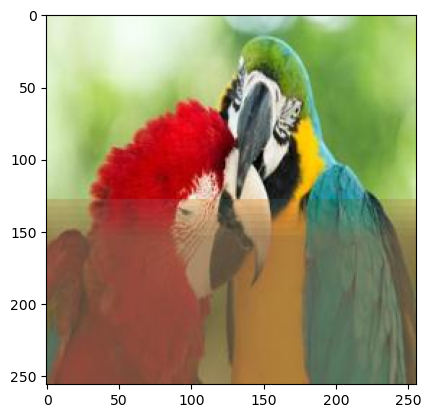

In [6]:
kk = cv2.imread("loritos_jesus_2.jpeg")
kk = cv2.cvtColor(kk, cv2.COLOR_BGR2RGB)/255.
plt.imshow(kk)
plt.show()
kk = kk[None,:]

In [9]:
@jax.jit
def forward_intermediates(state, inputs):
    return state.apply_fn({"params": state.params}, inputs, capture_intermediates=True)

In [10]:
%%time
outputs, extras = forward_intermediates(state, kk)
outputs.shape

CPU times: user 4.53 s, sys: 28.7 ms, total: 4.56 s
Wall time: 496 ms


(1, 64, 64, 128)

### Gamma Correction

In [11]:
if config.USE_GAMMA: layer_name = "GDNGamma_0"
else: layer_name = "GDN_0"
state.params[layer_name]

{'Conv_0': {'bias': array([0.20352368, 0.28535244, 0.3349554 ], dtype=float32),
  'kernel': array([[[[0.01672411, 0.14164323, 0.00340517]]]], dtype=float32)}}

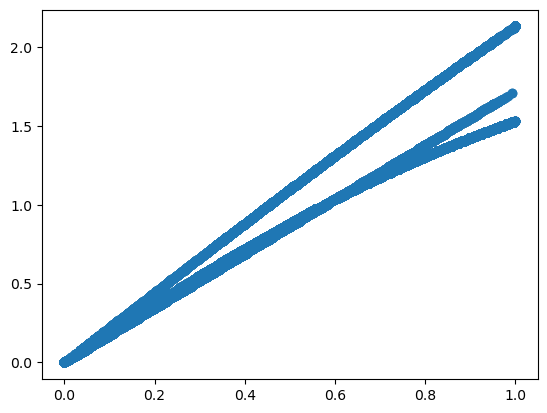

In [12]:
plt.scatter(kk.ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

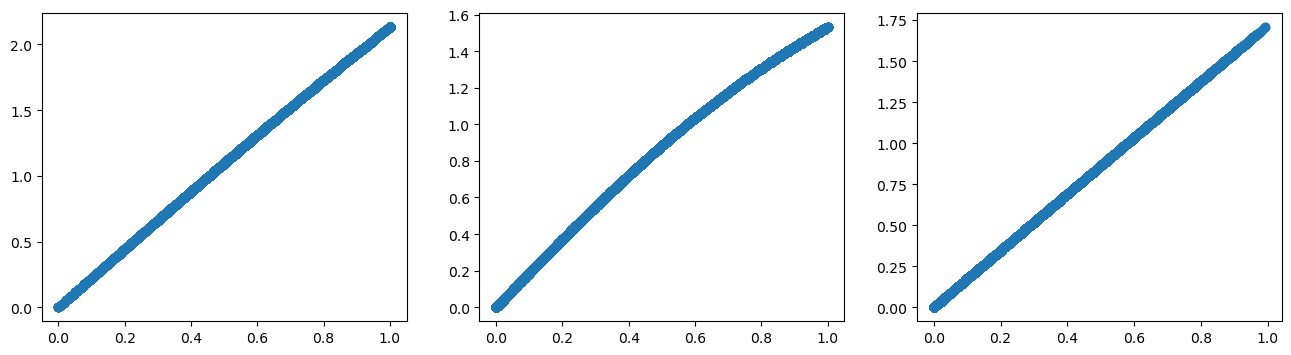

In [13]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
for i, ax in enumerate(axes.ravel()):
    ax.scatter(kk[...,i].ravel(),
            extras["intermediates"][layer_name]["__call__"][0][...,i].ravel())
plt.show()

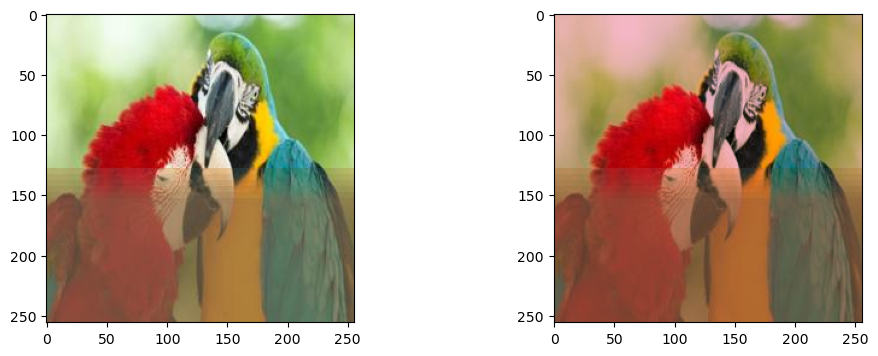

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].imshow(kk[0])
axes[1].imshow(extras["intermediates"][layer_name]["__call__"][0][0]/extras["intermediates"][layer_name]["__call__"][0][0].max())
plt.show()

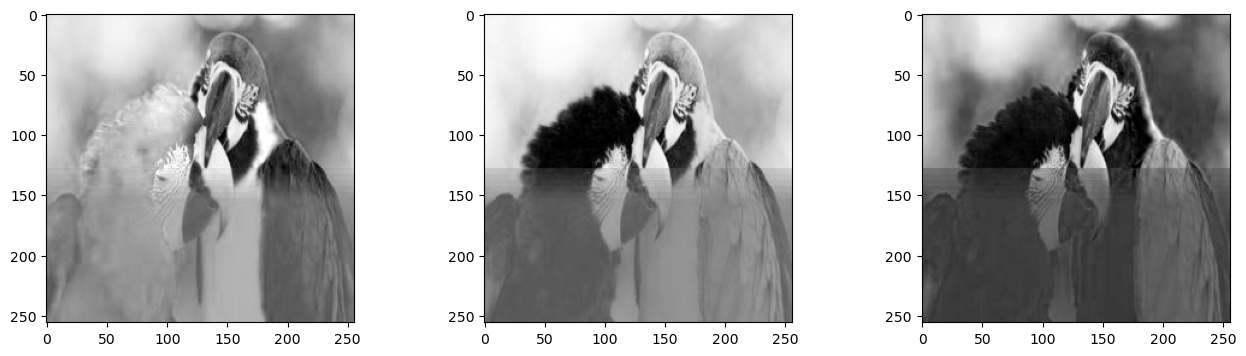

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
for i, ax in enumerate(axes):
    ax.imshow(extras["intermediates"][layer_name]["__call__"][0][0,:,:,i], cmap="gray")
plt.show()

### J & H

In [16]:
if config.USE_GAMMA: prev_layer = "GDNGamma_0"
else: prev_layer = "GDN_0"
layer_name = "Color"

In [17]:
state.params["Color"]

{'kernel': array([[[[ 0.25169665,  0.4473977 , -0.2849534 ],
          [ 0.7657371 , -0.50910735, -0.27115926],
          [ 0.10535581,  0.16286871, -0.19893458]]]], dtype=float32)}

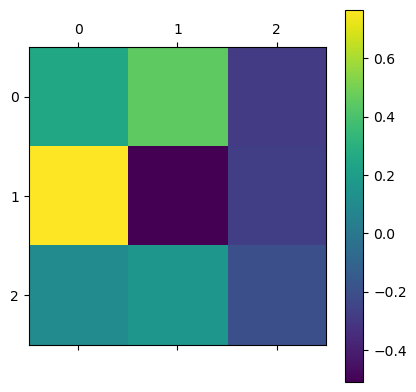

In [18]:
plt.matshow(state.params["Color"]["kernel"][0,0])
plt.colorbar()
plt.show()

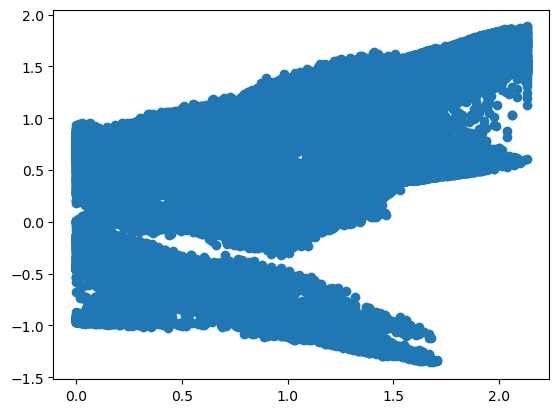

In [19]:
plt.scatter(extras["intermediates"][prev_layer]["__call__"][0].ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

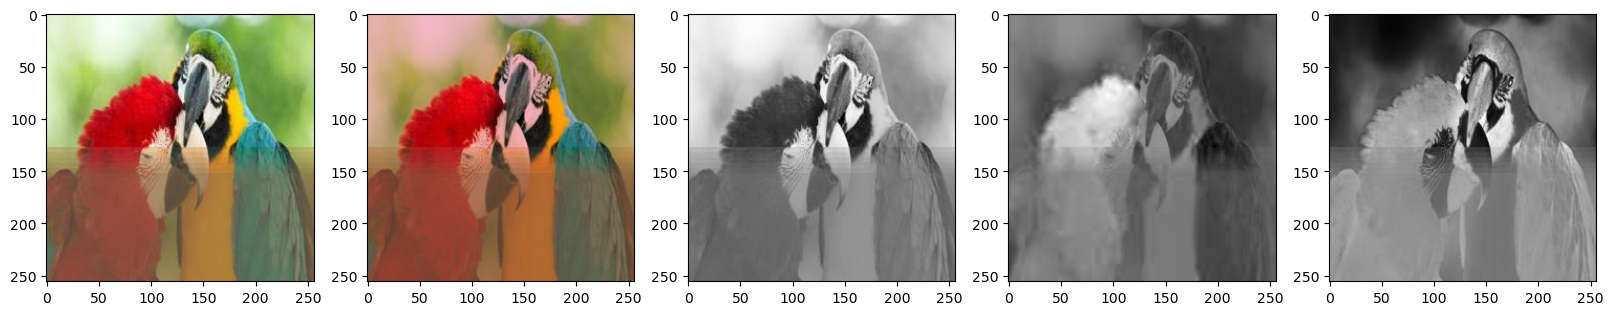

In [20]:
fig, axes = plt.subplots(1, 5, figsize=(20,4))
axes[0].imshow(kk[0])
axes[1].imshow(extras["intermediates"][prev_layer]["__call__"][0][0]/extras["intermediates"][prev_layer]["__call__"][0][0].max())
for i, ax in enumerate(axes[2:]):
    ax.imshow(extras["intermediates"][layer_name]["__call__"][0][0,:,:,i], cmap="gray")
plt.show()

### DN 1

In [21]:
# prev_layer = "Conv_0"
prev_layer = "Color"
if config.USE_GAMMA: layer_name = "GDN_0"
else: layer_name = "GDN_1"
state.params[layer_name]

{'Conv_0': {'bias': array([1.0260187, 0.6018284, 1.1229894], dtype=float32),
  'kernel': array([[[[3.0406806e-01, 1.9377743e+00, 1.2778337e-03]]]], dtype=float32)}}

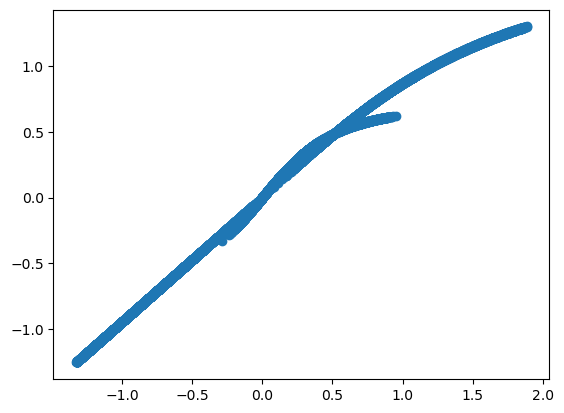

In [22]:
plt.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2)).ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

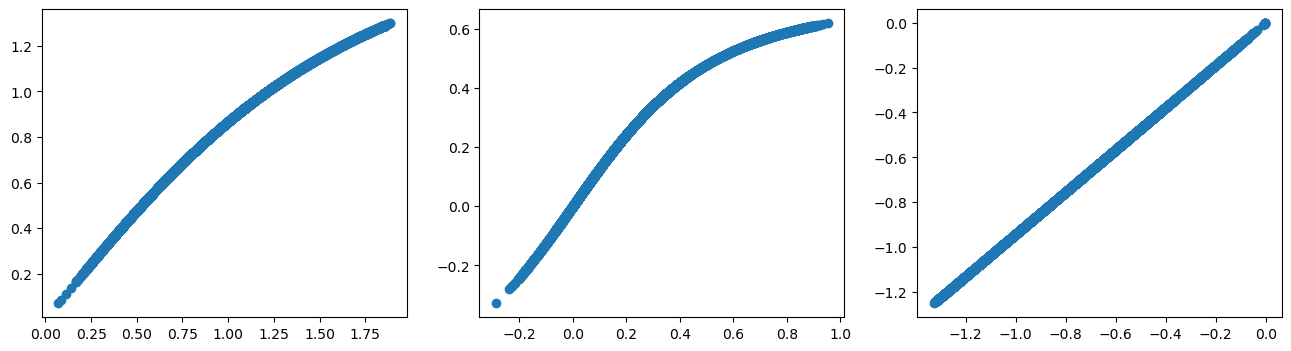

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
for i, ax in enumerate(axes):
    ax.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2))[0,:,:,i].ravel(),
               extras["intermediates"][layer_name]["__call__"][0][0,:,:,i].ravel())
plt.show()

### CSF (DoG)

In [24]:
prev_layer = "GDN_1"
layer_name = "Conv_0"
# state.params[layer_name]

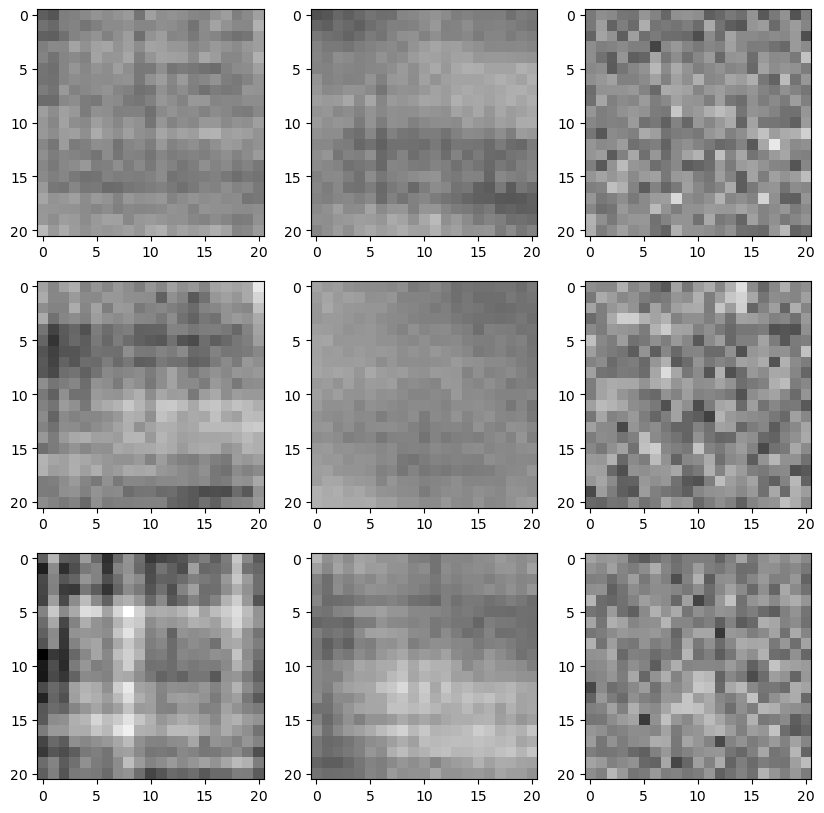

In [25]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))
m, M = state.params[layer_name]["kernel"].min(), state.params[layer_name]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.params[layer_name]["kernel"][:,:,i,j], vmin=m, vmax=M, cmap="gray")
        # ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

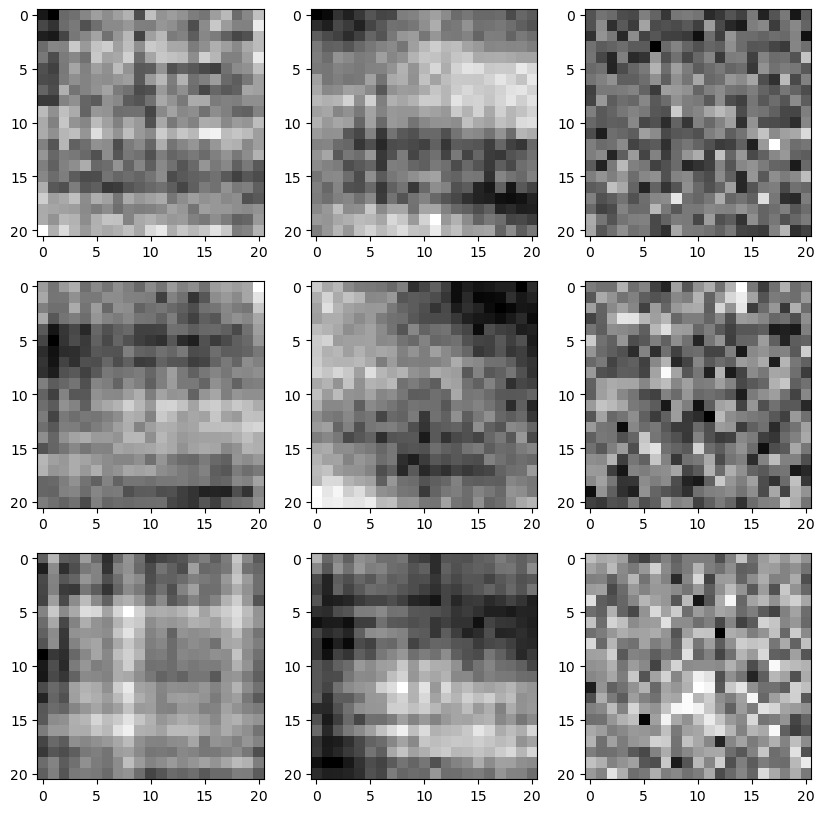

In [26]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))
m, M = state.params[layer_name]["kernel"].min(), state.params[layer_name]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.params[layer_name]["kernel"][:,:,i,j], cmap="gray")
        # ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

### DN (2)

In [27]:
state.params.keys()

dict_keys(['Color', 'Conv_0', 'Conv_1', 'GDN_0', 'GDN_1', 'GDN_2', 'GDN_3'])

In [28]:
prev_layer = "Conv_0"
layer_name = "GDN_2"
# state.params[layer_name]

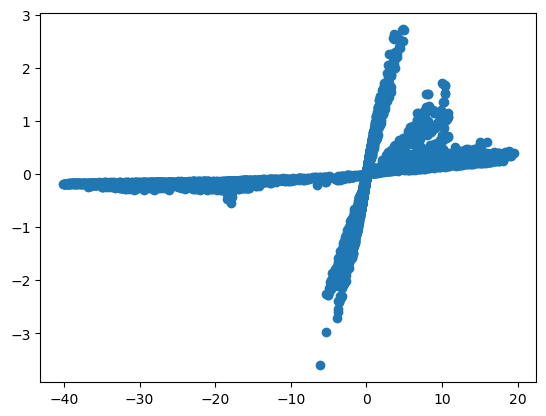

In [29]:
plt.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2)).ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

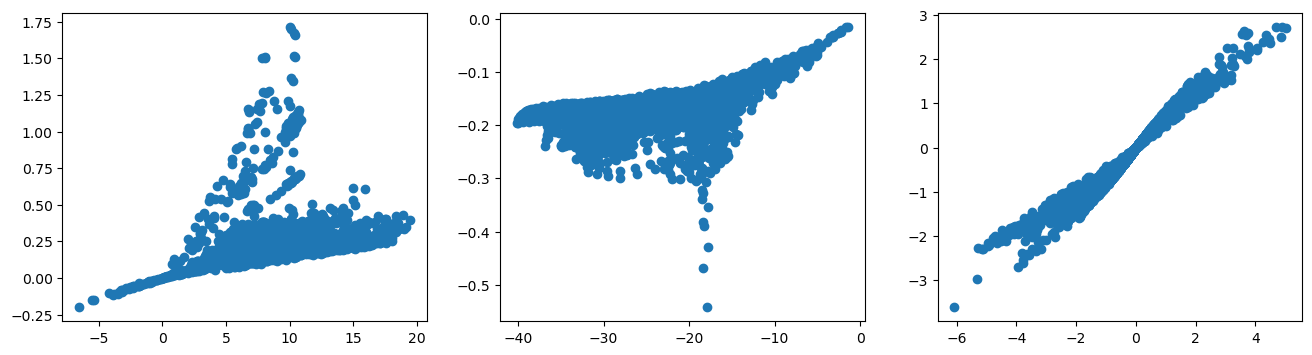

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
for i, ax in enumerate(axes):
    ax.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2))[0,:,:,i].ravel(),
               extras["intermediates"][layer_name]["__call__"][0][0,:,:,i].ravel())
plt.show()

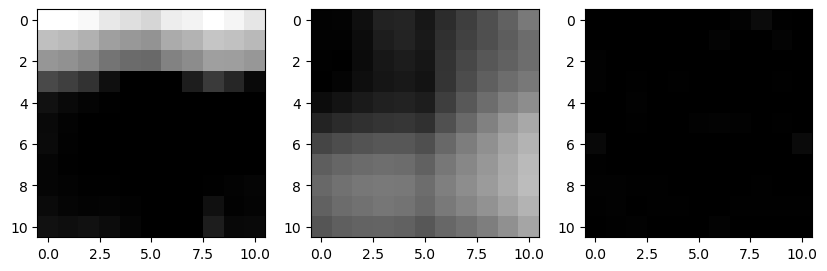

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(10,10), squeeze=False)
m, M = state.params[layer_name]["Conv_0"]["kernel"].min(), state.params[layer_name]["Conv_0"]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.params[layer_name]["Conv_0"]["kernel"][:,:,i,j], vmin=m, vmax=M, cmap="gray")
        # ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

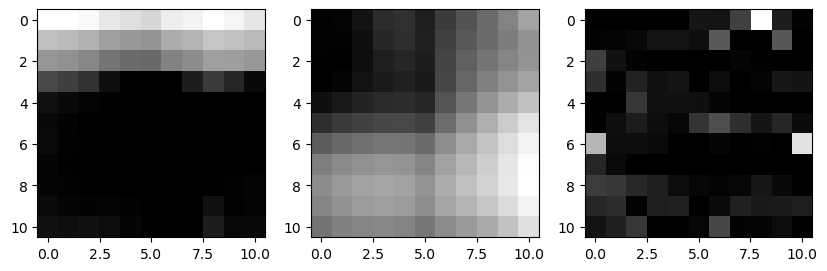

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(10,10), squeeze=False)
m, M = state.params[layer_name]["Conv_0"]["kernel"].min(), state.params[layer_name]["Conv_0"]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.params[layer_name]["Conv_0"]["kernel"][:,:,i,j], cmap="gray")
        # ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

### Gabor

In [33]:
prev_layer = "GDN_2"
layer_name = "Conv_1"
# state.params[layer_name]

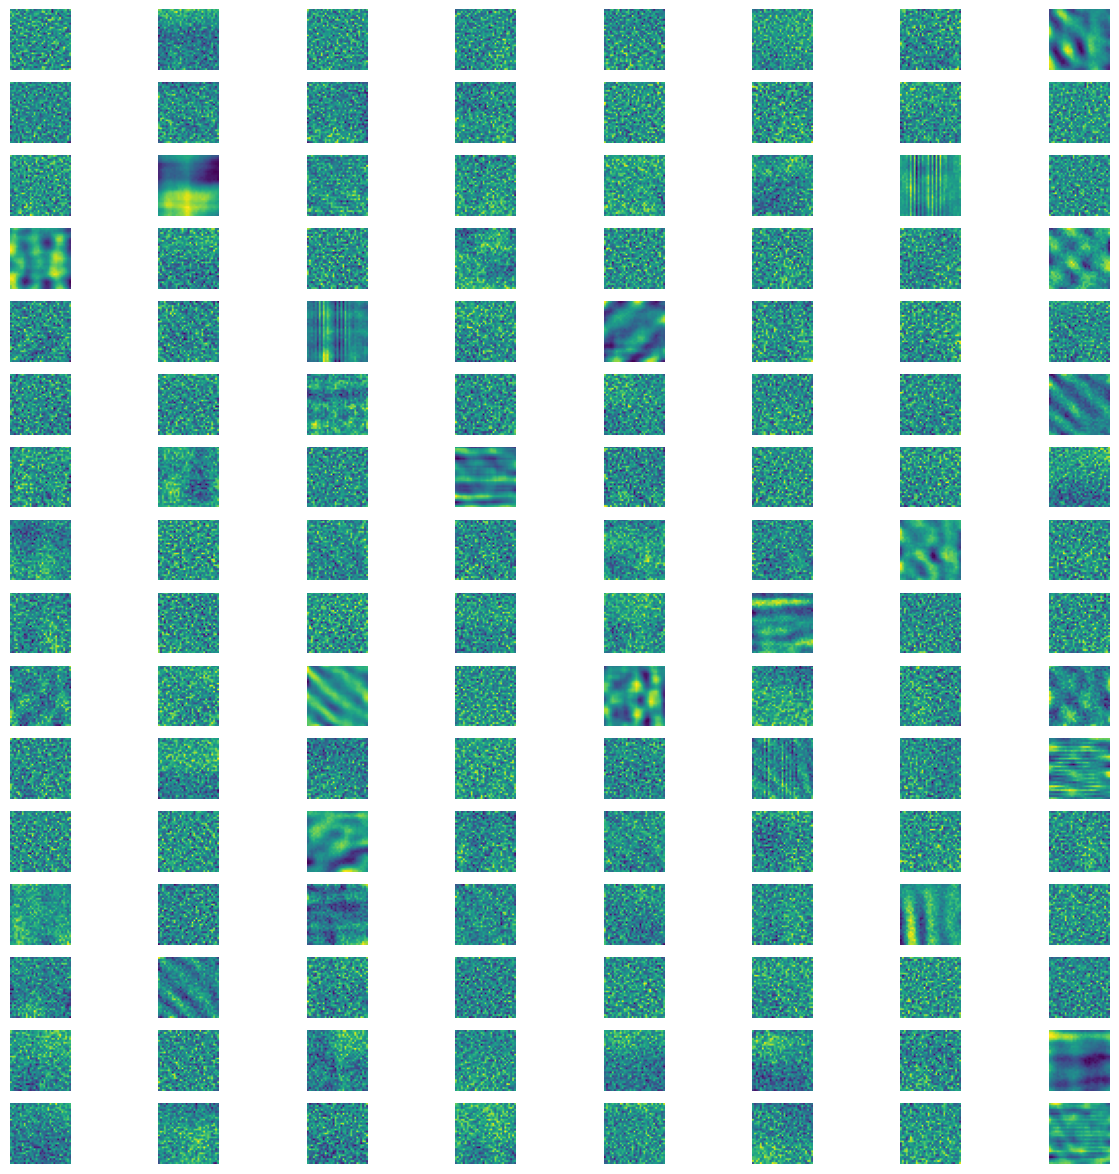

In [34]:
fig, axes = plt.subplots(16,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.params[layer_name]["kernel"][:,:,0,i])
    ax.axis("off")
plt.show()

In [36]:
kernel = state.params[layer_name]["kernel"]
kernel_f_fft = jnp.fft.fftn(kernel[:,:,0,:], axes=(0,1))
kernel_f_fft = jnp.fft.fftshift(kernel_f_fft)
kernel_f_fft_abs_sum = jnp.abs(kernel_f_fft).sum(axis=-1)
kernel_f_fft.shape, kernel_f_fft_abs_sum.shape

((31, 31, 128), (31, 31))

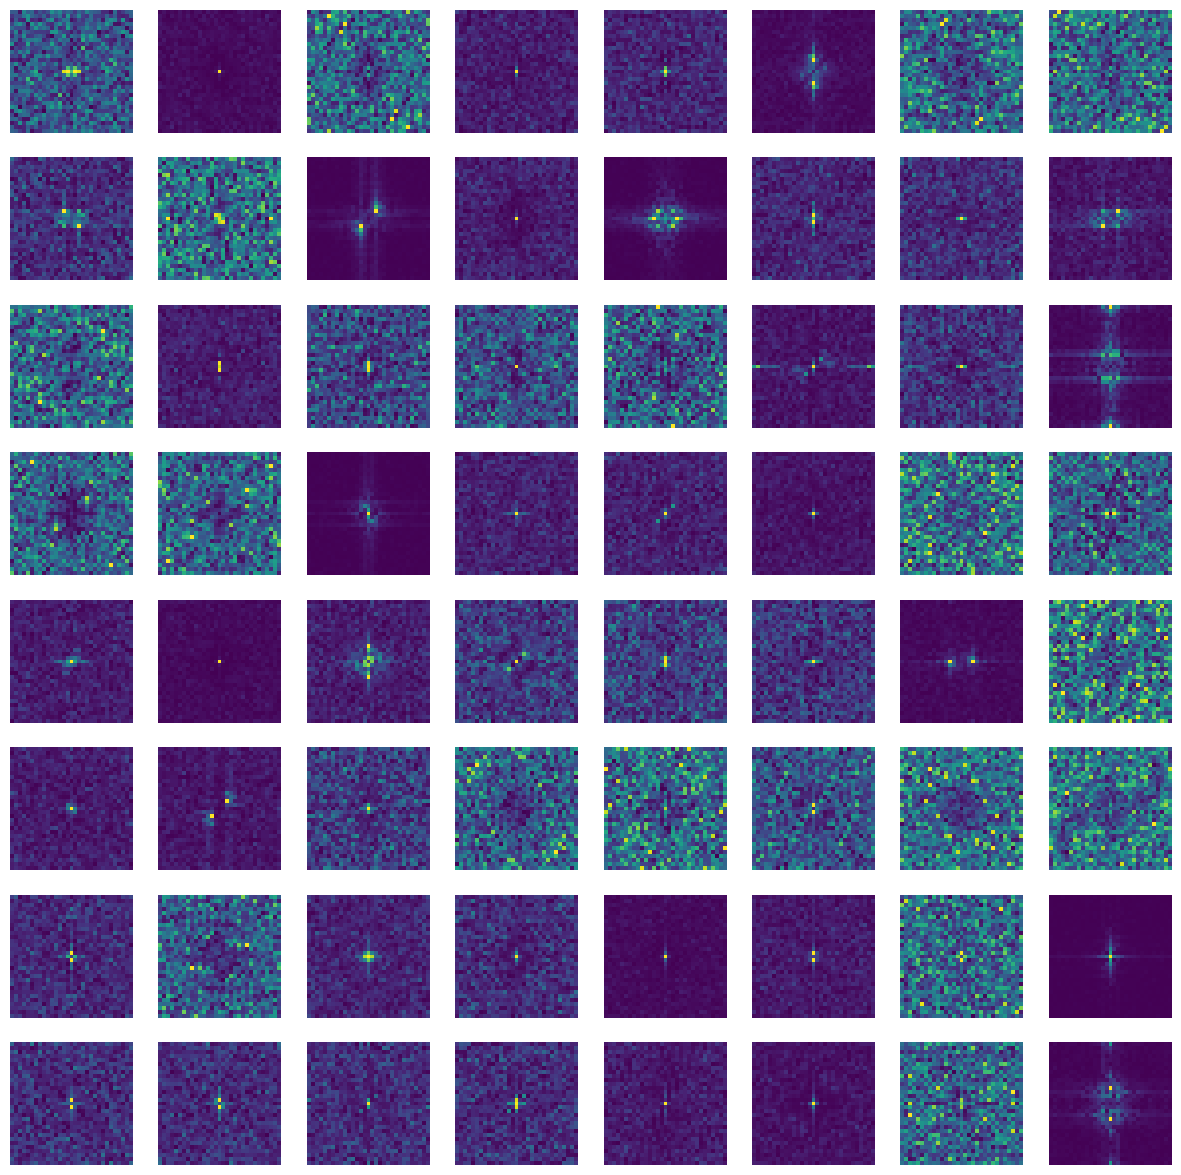

In [39]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(jnp.abs(kernel_f_fft[:,:,i]))
    ax.axis("off")
plt.show()

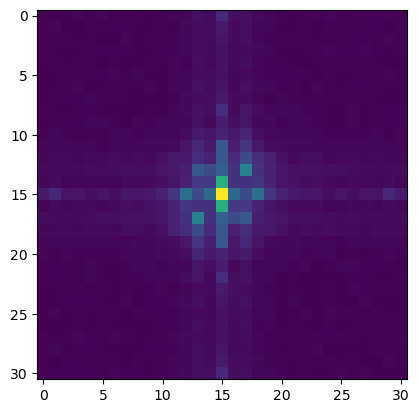

In [37]:
plt.imshow(kernel_f_fft_abs_sum)
plt.show()

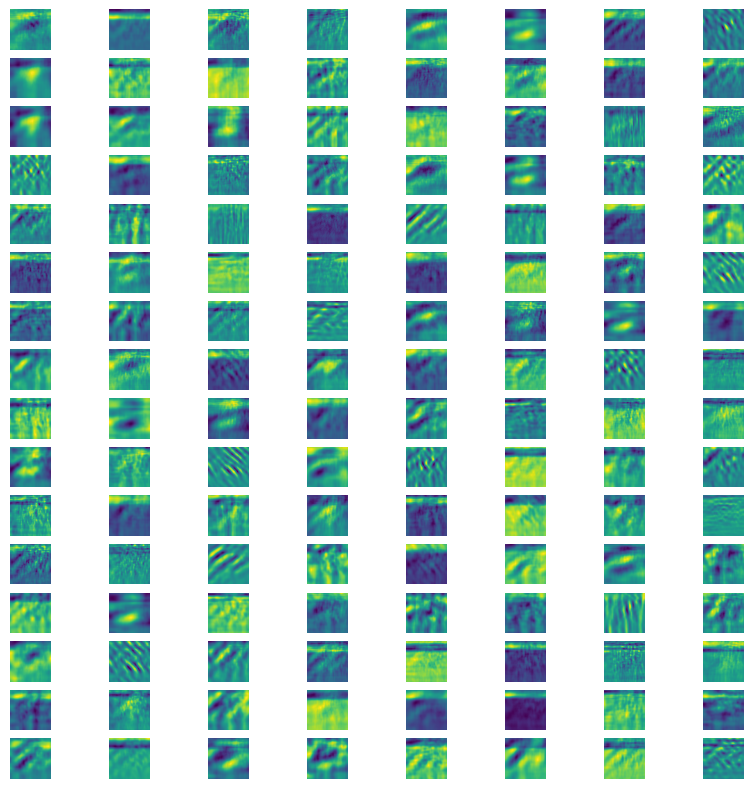

In [38]:
fig, axes = plt.subplots(16, 8, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    ax.imshow(extras["intermediates"][layer_name]["__call__"][0][0,:,:,i])
    ax.axis("off")
plt.show()
plt.show()

### DN (3)

In [40]:
prev_layer = "Conv_1"
layer_name = "GDN_3"
# state.params[layer_name]

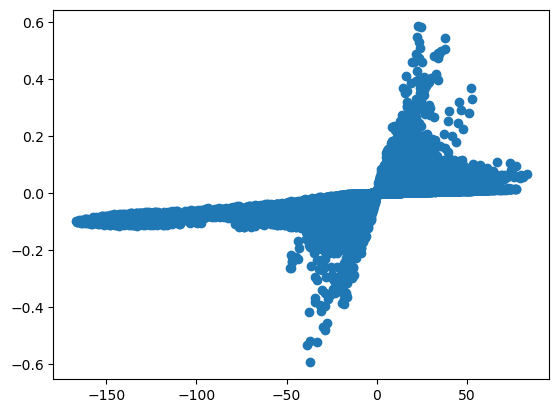

In [41]:
plt.scatter(extras["intermediates"][prev_layer]["__call__"][0].ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

In [42]:
extras["intermediates"][prev_layer]["__call__"][0].shape

(1, 64, 64, 128)

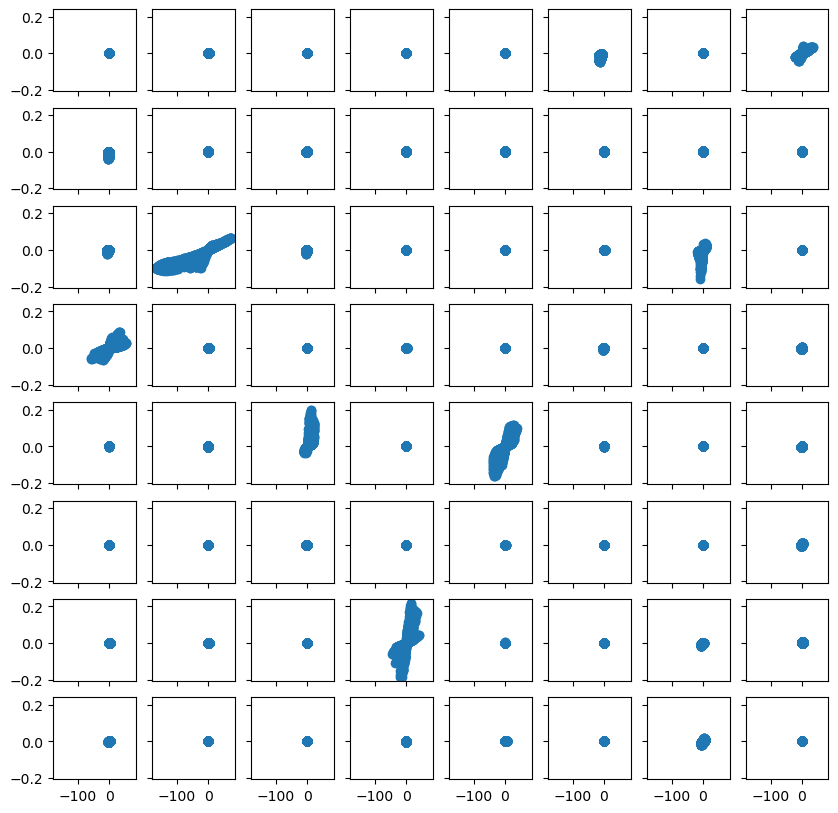

In [43]:
fig, axes = plt.subplots(8, 8, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    ax.scatter(extras["intermediates"][prev_layer]["__call__"][0][0,:,:,i].ravel(),
               extras["intermediates"][layer_name]["__call__"][0][0,:,:,i].ravel())
plt.show()
plt.show()

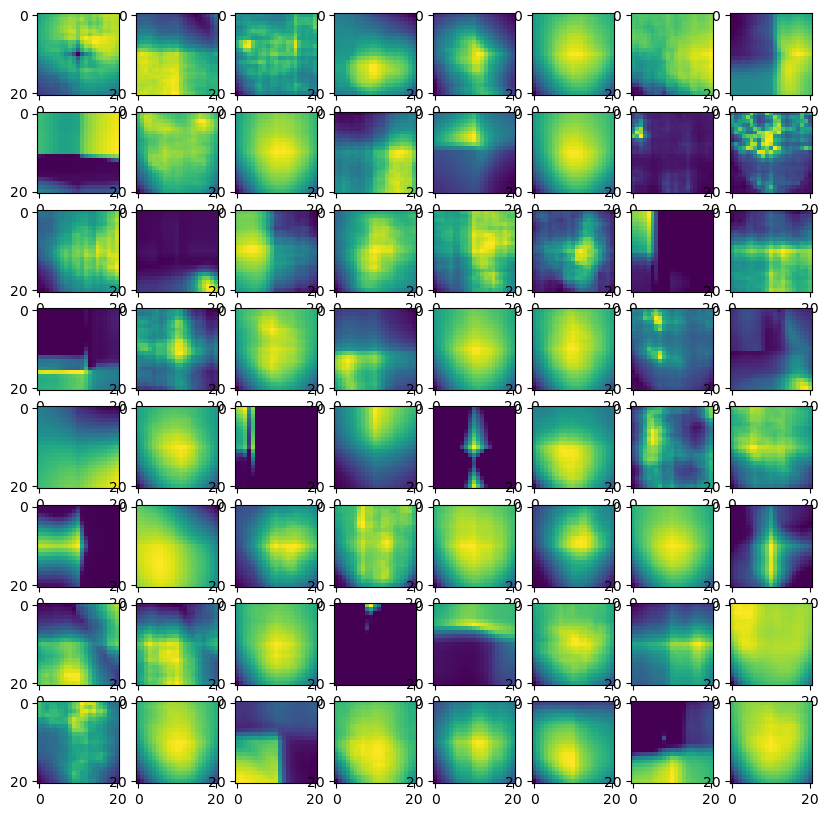

In [44]:
fig, axes = plt.subplots(8, 8, figsize=(10,10))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.params[layer_name]["Conv_0"]["kernel"][:,:,0,i])
plt.show()

### Final output

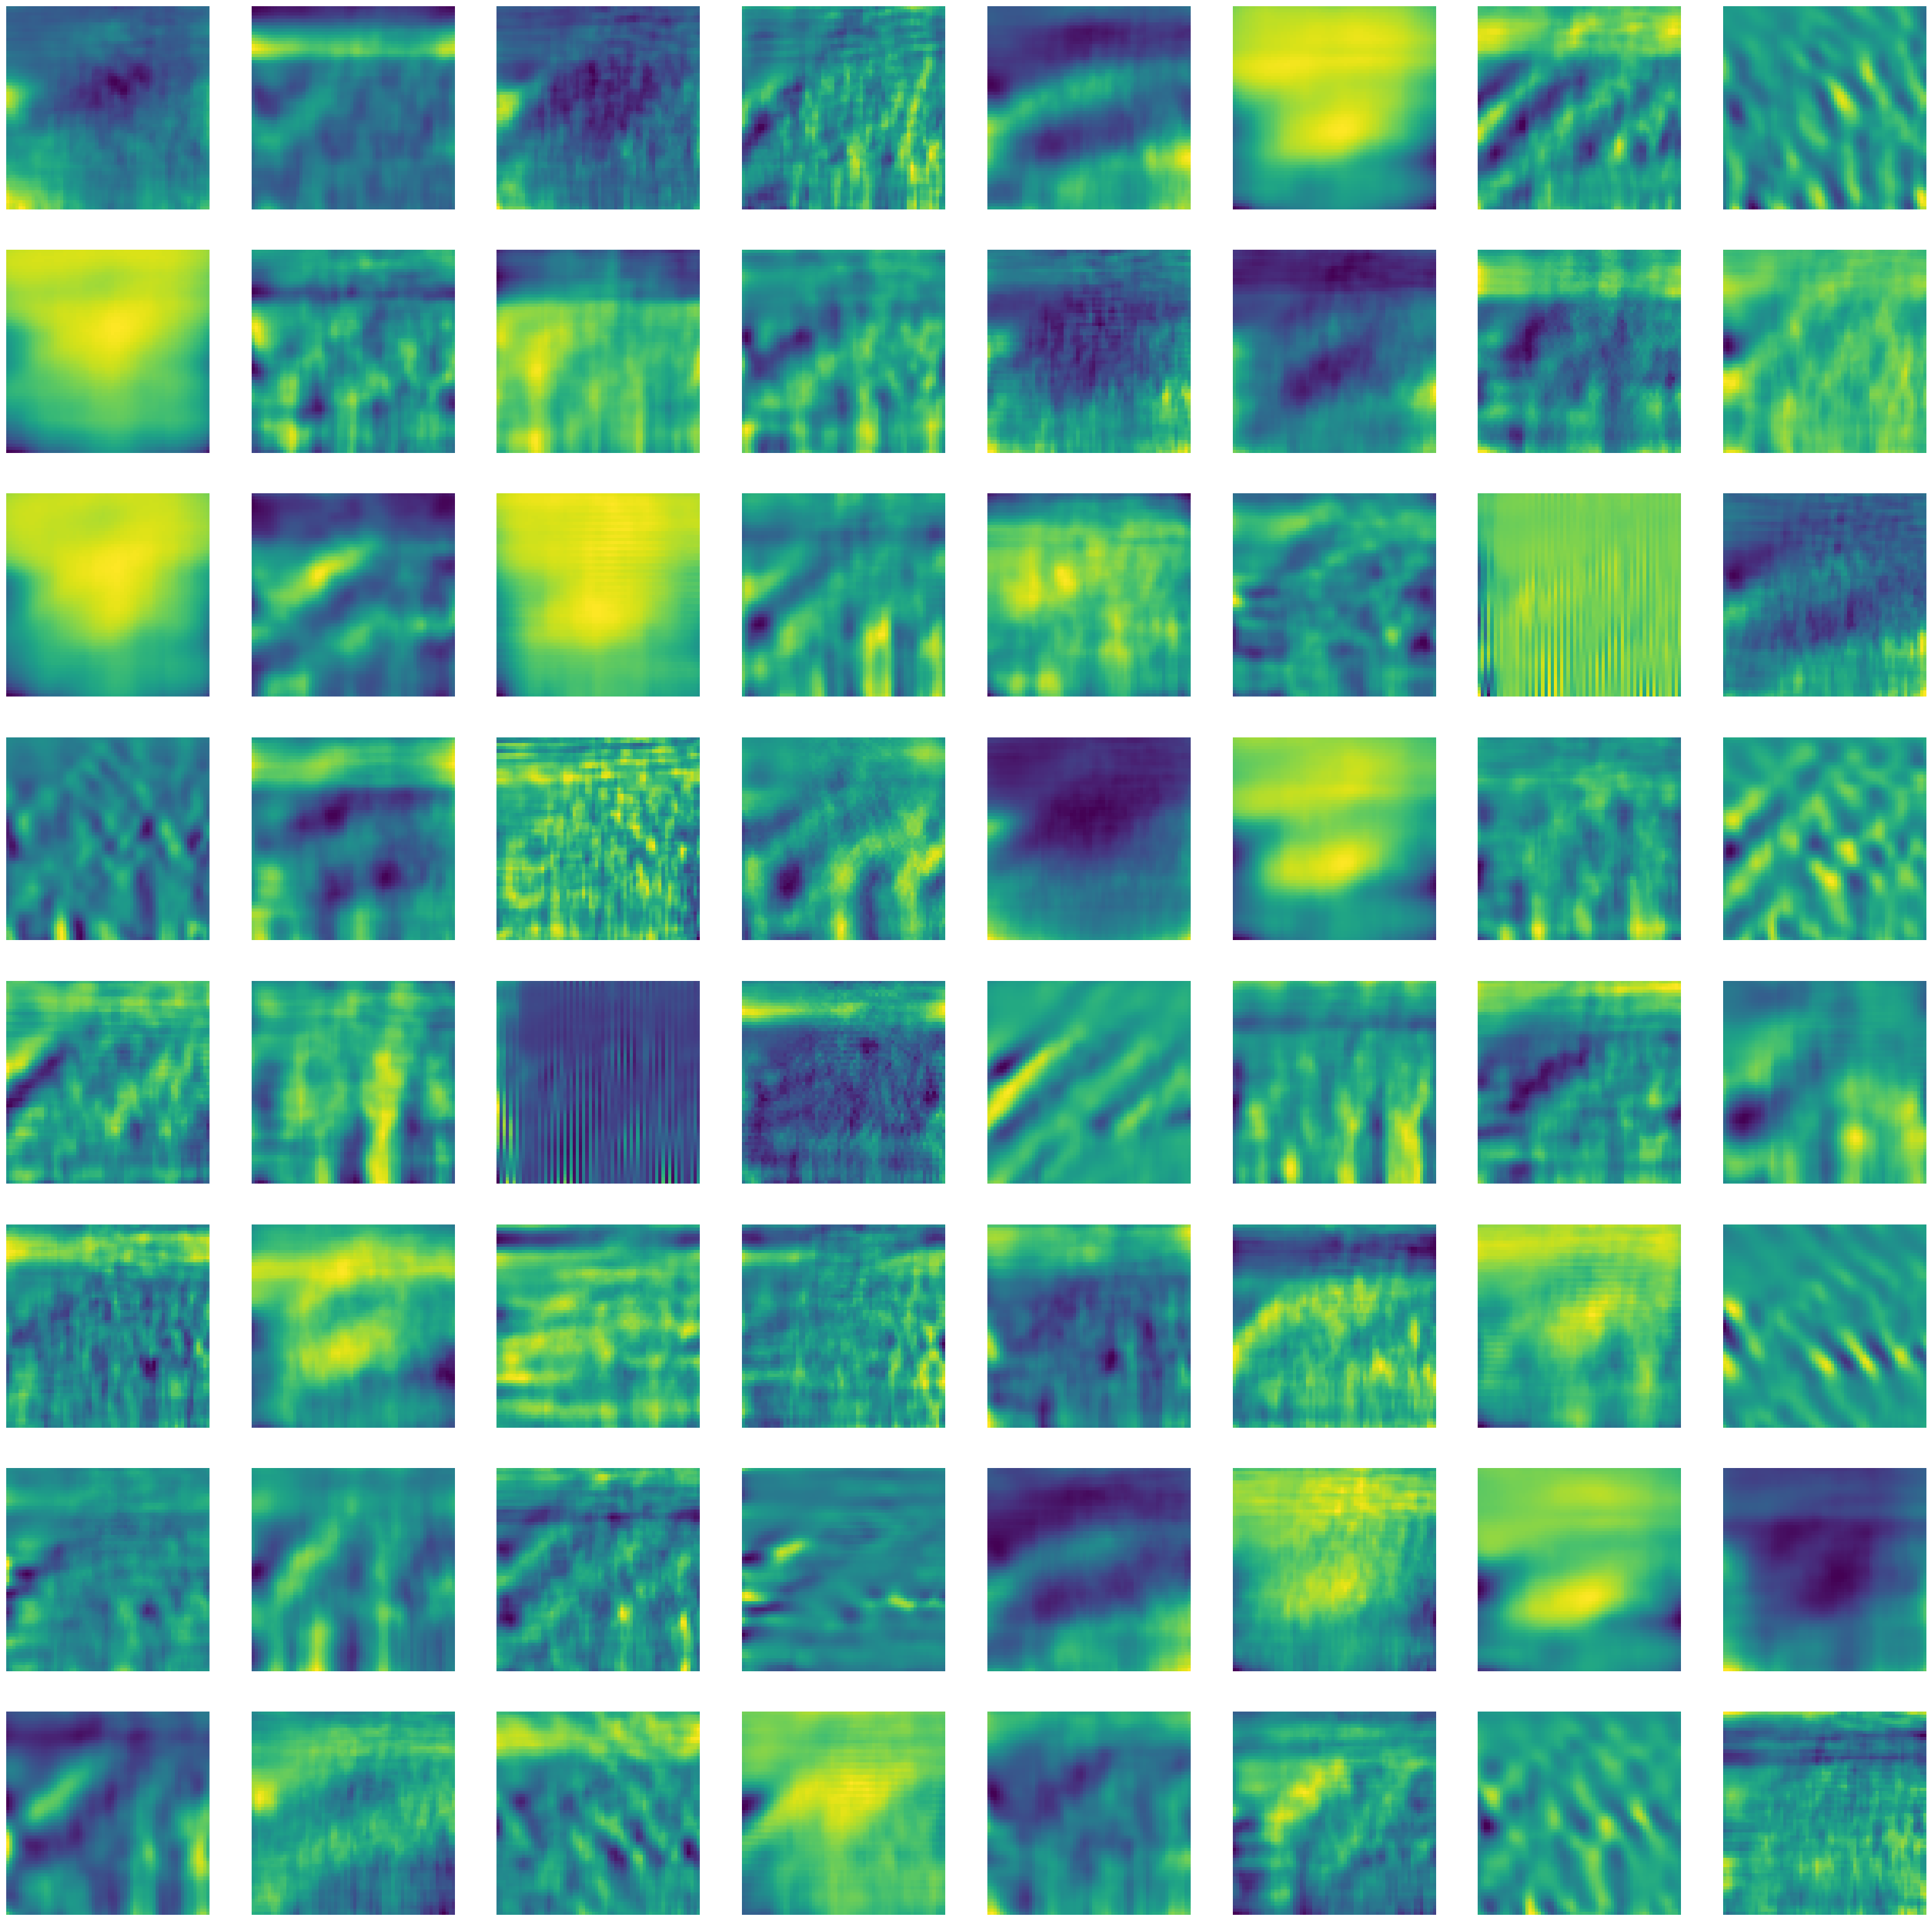

In [45]:
fig, axes = plt.subplots(8,8, figsize=(40,40))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(outputs[0,:,:,i])
    ax.axis("off")
plt.show()